### <b>StyleCLIP Tutorial</b>

* This is a simple tutorial with source code for <b>[StyleCLIP](https://arxiv.org/abs/2103.17249)</b>.
* <b>Reference</b>: [Original StyleCLIP source code](https://github.com/orpatashnik/StyleCLIP)

#### <b>Install CLIP</b>

* CLIP jointly trains an image encoder and a text encoder using a large dataset.
* The cosine similarity between an image and text feature is high if they have similar semantic meanings.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


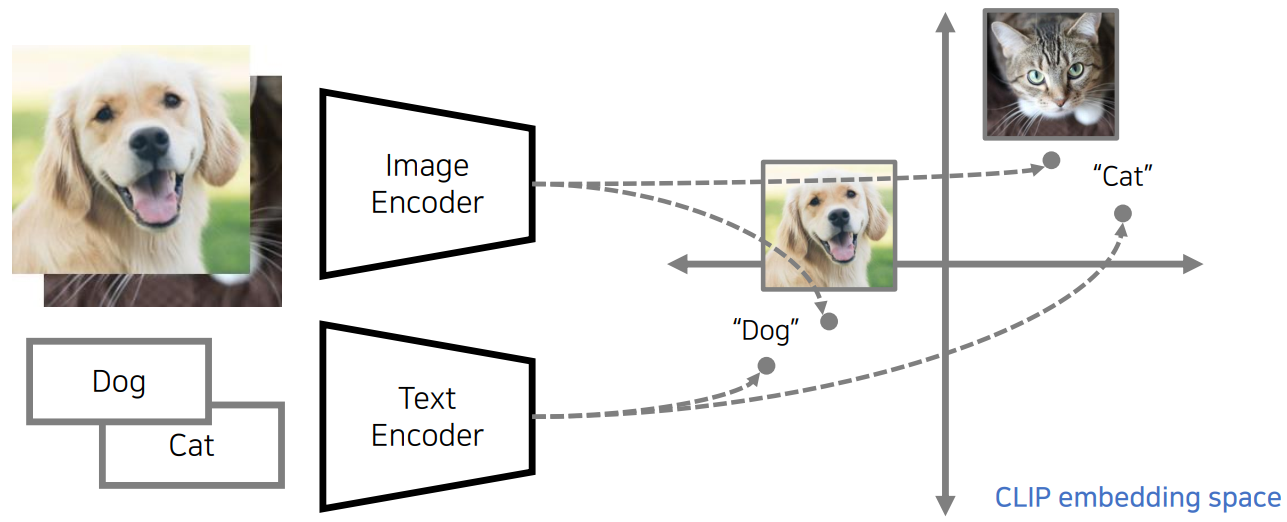

In [19]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-is5v213_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-is5v213_
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


#### <b>Load the Pre-trained StyleGAN Model</b>

* StyleGAN is an efficient architecture to generate high-quality images.

In [20]:
!git clone https://github.com/ndb796/StyleCLIP-Tutorial
%cd StyleCLIP-Tutorial

Cloning into 'StyleCLIP-Tutorial'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 64 (delta 19), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (64/64), 3.33 MiB | 5.77 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/StyleCLIP-Tutorial/StyleCLIP-Tutorial


In [21]:
import torch
from stylegan2.model import Generator

g_ema = Generator(1024, 512, 8) # channel_multiplier = 1로 맞춰야 사이즈 misalign이 안 일어나서 제대로 동작합니다.
g_ema.load_state_dict(torch.load('/content/drive/MyDrive/Lecture/AI-Intro/textures.pt')["g_ema"], strict=False) # 모델 파일(.pt)을 루트 폴더 위치에 올리고 실행하면 됩니다.
g_ema.eval()
g_ema = g_ema.cuda()

#### <b>CLIP Loss</b>

In [22]:
import clip


class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity

#### <b>Latent Optimization</b>

* The basic idea is as follows:

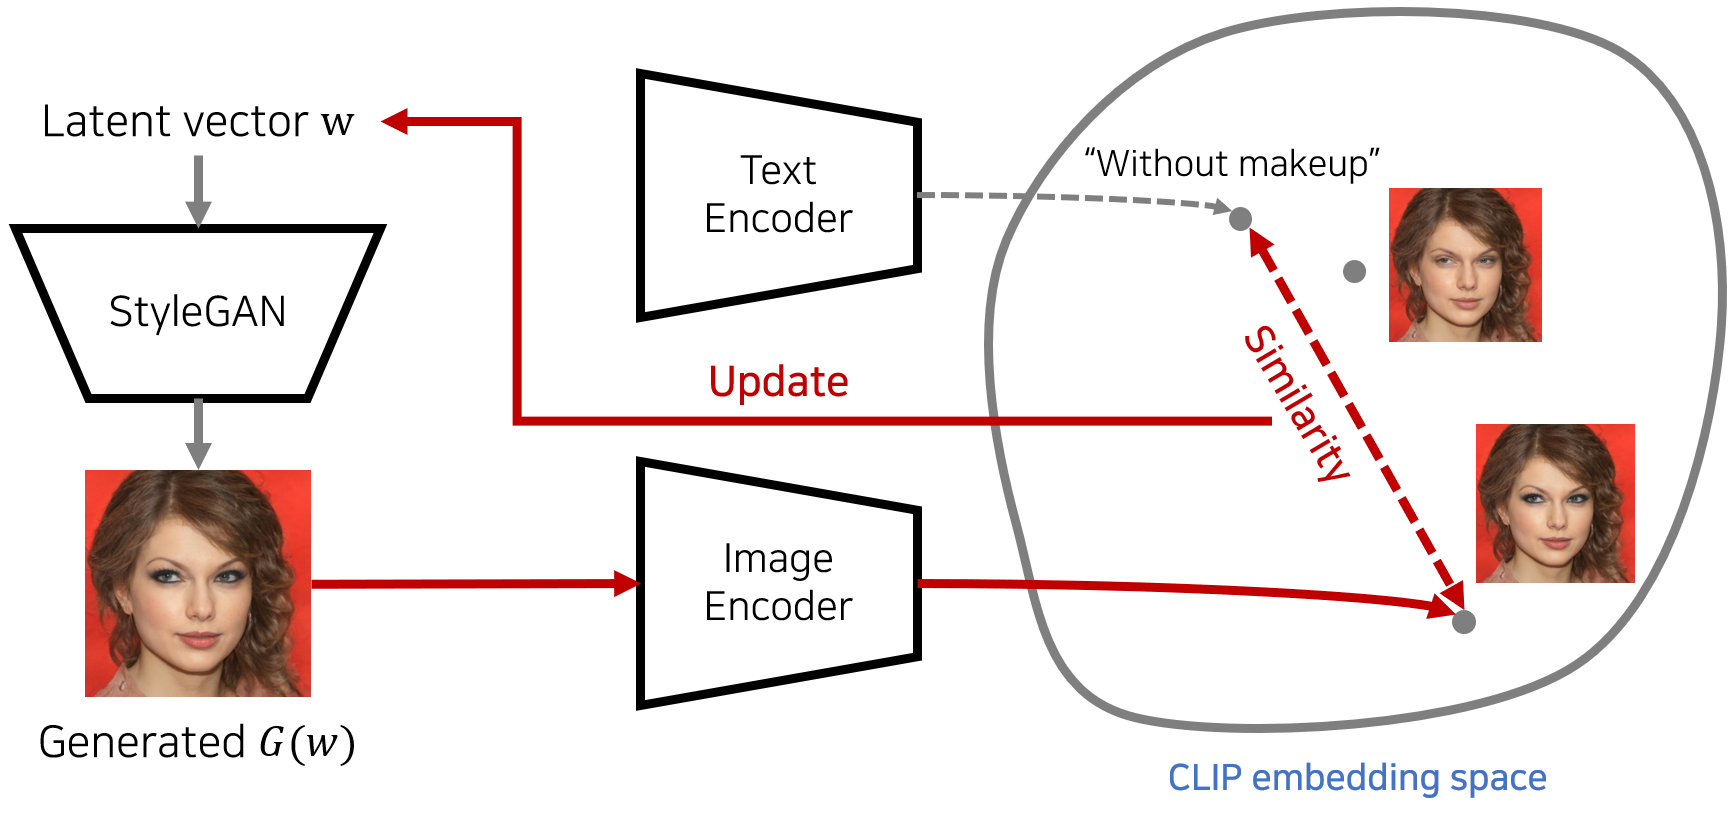

* Initialize a random latent vector using a mean latent vector.

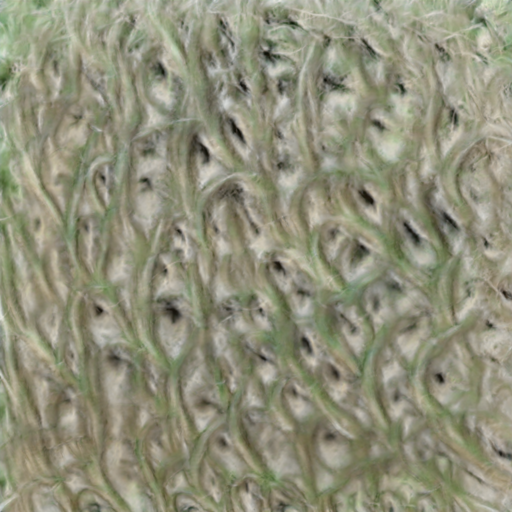

In [89]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage


mean_latent = g_ema.mean_latent(4096)

latent_code_init_not_trunc = torch.randn(1, 512).cuda()
with torch.no_grad():
    img_orig, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
                                truncation=0.7, truncation_latent=mean_latent)

# Visualize a random latent vector.
image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, value_range=(-1, 1), padding=0))
h, w = image.size
image.resize((h // 2, w // 2))

* The optimization method updates the $w$ vector.
* In this source code, we use only $D_{CLIP}(G(w),t) + \lambda_{L2} ||w-w_s||_2$.

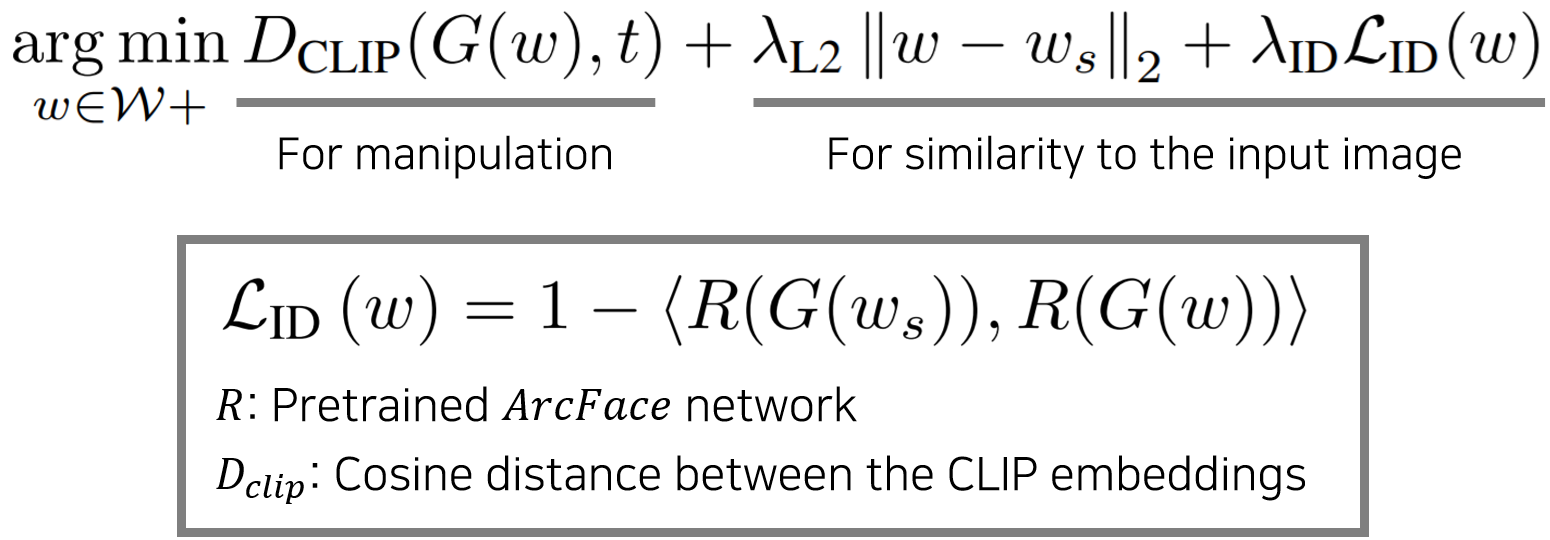

* Set parameters for a practice.

In [99]:
from argparse import Namespace


args = Namespace()
args.description = 'Smooth'
args.lr_rampup = 0.05
args.lr = 0.2
args.step = 100
args.l2_lambda = 0.001
args.save_intermediate_image_every = 1
args.results_dir = 'results'

* Optimize a latent vector and get the result.

In [100]:
import os
import math
import torchvision
from torch import optim


# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp


text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
os.makedirs(args.results_dir, exist_ok=True)

# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr)

for i in range(args.step):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr)
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)
    l2_loss = ((latent_code_init - latent) ** 2).sum()
    loss = c_loss + args.l2_lambda * l2_loss

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    print(f"lr: {lr}, loss: {loss.item():.4f}")
    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.png", normalize=True, value_range=(-1, 1))

with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir, "final_result.jpg"), normalize=True, scale_each=True, value_range=(-1, 1))

lr: 0.0, loss: 0.7861
lr: 0.04, loss: 0.7861
lr: 0.08, loss: 0.8042
lr: 0.12, loss: 0.8228
lr: 0.16, loss: 0.8857
lr: 0.2, loss: 0.9565
lr: 0.2, loss: 0.9810
lr: 0.2, loss: 0.9600
lr: 0.2, loss: 0.9434
lr: 0.2, loss: 0.9849
lr: 0.2, loss: 0.9941
lr: 0.2, loss: 1.0137
lr: 0.2, loss: 1.0361
lr: 0.2, loss: 1.0283
lr: 0.2, loss: 1.0020
lr: 0.2, loss: 0.9692
lr: 0.2, loss: 0.9375
lr: 0.2, loss: 0.9131
lr: 0.2, loss: 0.8989
lr: 0.2, loss: 0.8901
lr: 0.2, loss: 0.8784
lr: 0.2, loss: 0.8677
lr: 0.2, loss: 0.8789
lr: 0.2, loss: 0.8730
lr: 0.2, loss: 0.8774
lr: 0.2, loss: 0.8862
lr: 0.2, loss: 0.9009
lr: 0.2, loss: 0.9224
lr: 0.2, loss: 0.9238
lr: 0.2, loss: 0.9194
lr: 0.2, loss: 0.9053
lr: 0.2, loss: 0.8799
lr: 0.2, loss: 0.8662
lr: 0.2, loss: 0.8755
lr: 0.2, loss: 0.8906
lr: 0.2, loss: 0.8838
lr: 0.2, loss: 0.9014
lr: 0.2, loss: 0.8823
lr: 0.2, loss: 0.8857
lr: 0.2, loss: 0.8931
lr: 0.2, loss: 0.8999
lr: 0.2, loss: 0.8936
lr: 0.2, loss: 0.8799
lr: 0.2, loss: 0.8691
lr: 0.2, loss: 0.8652
lr: 0.

#### <b>Result Visualization</b>

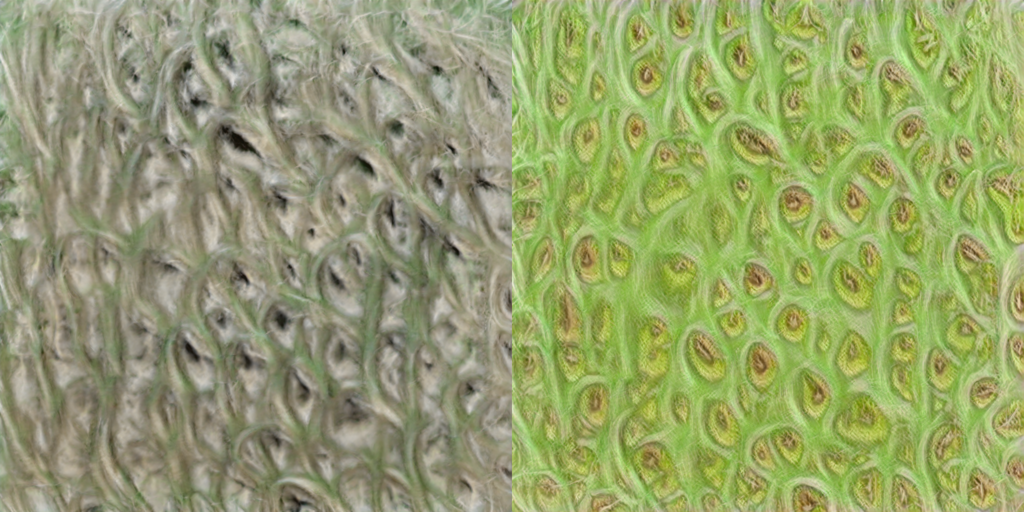

In [101]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, value_range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

* Generate an animation video and download the video.

In [ ]:
!ffmpeg -r 15 -i results/%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4

from google.colab import files
files.download('out.mp4')

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>